In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
import datetime

import utils
import exploration as exp
import pipeline as pipe

pd.set_option('display.max_rows', 1000)

In [3]:
data_dir = Path("../data/")
raw = pd.read_csv(data_dir/"Business_Licenses.csv")
bizraw.sort_values('LEGAL NAME').head()

In [5]:
# basic cleaning
time_cols = ['LICENSE TERM START DATE',
             'LICENSE TERM EXPIRATION DATE',
             'LICENSE STATUS CHANGE DATE',
             'DATE ISSUED']

df = pd.read_csv(data_dir/"Business_Licenses.csv", parse_dates = time_cols)
df.info()

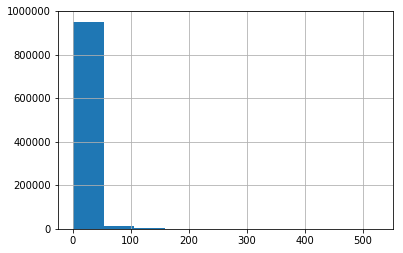

In [6]:
df['SITE NUMBER'].hist()

In [7]:
df.groupby(['APPLICATION TYPE', 'LICENSE STATUS']).count()

ID  LICENSE ID  ACCOUNT NUMBER  \
APPLICATION TYPE LICENSE STATUS                                       
C_CAPA           AAC                 18          18              18   
                 AAI                461         461             461   
C_EXPA           AAC                 45          45              45   
                 AAI                642         642             642   
                 REV                  2           2               2   
C_LOC            AAC                632         632             632   
                 AAI              11664       11664           11664   
                 REV                  5           5               5   
C_SBA            AAC                  7           7               7   
                 AAI                407         407             407   
ISSUE            AAC              16271       16271           16271   
                 AAI             201168      201168          201168   
                 INQ                  4           4               4   
                 REV                228         228             228   
RENEW            AAC              48206       48206           48206   
                 AAI             688233      688233          688233   
                 INQ                  2           2               2   
                 REA                 11          11              11   
                 REV                739         739             739   

                                 SITE NUMBER  LEGAL NAME  \
APPLICATION TYPE LICENSE STATUS                            
C_CAPA           AAC                      18          18   
                 AAI                     461         461   
C_EXPA           AAC                      45          45   
                 AAI                     642         642   
                 REV                       2           2   
C_LOC            AAC                     632         632   
                 AAI                   11664       11664   
                 REV                       5           5   
C_SBA            AAC                       7           7   
                 AAI                     407         407   
ISSUE            AAC                   16271       16271   
                 AAI                  201168      201167   
                 INQ                       4           4   
                 REV                     228         228   
RENEW            AAC                   48206       48206   
                 AAI                  688233      688230   
                 INQ                       2           2   
                 REA                      11          11   
                 REV                     739         739   

                                 DOING BUSINESS AS NAME  ADDRESS    CITY  \
APPLICATION TYPE LICENSE STATUS                                            
C_CAPA           AAC                                 18       18      18   
                 AAI                                461      461     461   
C_EXPA           AAC                                 45       45      45   
                 AAI                                642      642     642   
                 REV                                  2        2       2   
C_LOC            AAC                                630      632     632   
                 AAI                              11650    11664   11664   
                 REV                                  5        5       5   
C_SBA            AAC                                  7        7       7   
                 AAI                                407      407     407   
ISSUE            AAC                              16268    16271   16271   
                 AAI                             201139   201168  201166   
                 INQ                                  4        4       4   
                 REV                                228      228     228   
RENEW            AAC                              48206    48206   4

In [20]:
businesses = df[['LEGAL NAME', 'ACCOUNT NUMBER']].drop_duplicates().sort_values(['ACCOUNT NUMBER'])
print(businesses.shape)
print(businesses.nunique())

(165162, 2)
LEGAL NAME        162922
ACCOUNT NUMBER    165162
dtype: int64


LICENSE STATUS:

‘AAI’ means the license was issued.
‘AAC’ means the license was cancelled during its term.
‘REV’ means the license was revoked.
'REA' means the license revocation has been appealed.
APPLICATION TYPE:

‘ISSUE’ is the record associated with the initial license application.
‘RENEW’ is a subsequent renewal record. All renewal records are created with a term start date and term expiration date.
‘C_LOC’ is a change of location record. It means the business moved.
‘C_CAPA’ is a change of capacity record. Only a few license types may file this type of application.
‘C_EXPA’ only applies to businesses that have liquor licenses. It means the business location expanded.
'C_SBA' is a change of business activity record. It means that a new business activity was added or an existing business activity was marked as expired.
What do we think about cancellations for applications to expand or to change locations or business activities? Does this mean the whole business failed or does it mean they canceled their plans? Maybe this has the same result for a neighborhood.

*4 cases we might care about:*
1. License revoked or canceled => it's dead
2. License not renewed and expiration date is before T2 => it's dead
3. License renewed during T0-T2 => it's alive
4. License not renewed and expiration date is after T2 => ...it's alive?

In [9]:
# case 1, license is revoked or canceled - about 66,000 examples in dataset, mostly cancellations
df['revoked'] = np.where(df['LICENSE STATUS'] == 'REV', 1, 0)
df['canceled'] = np.where(df['LICENSE STATUS'] == 'AAC', 1, 0)
df['failed'] = np.where(df['revoked'] + df['canceled'] > 0, 1, 0)
df[['revoked', 'canceled', 'failed']].sum()

revoked       974
canceled    65179
failed      66153
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c95a33b00>,
      dtype=object)

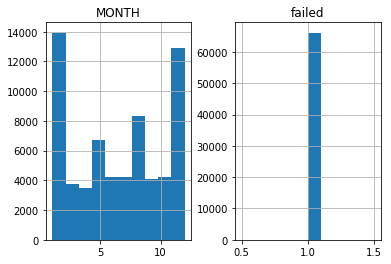

In [19]:
# failure tend to happen at the beginning/end of the year, or quarters
df['MONTH'] = df['LICENSE TERM START DATE'].dt.month
df[['failed', 'MONTH']].loc[df['failed'] == 1].hist()

Renewals and non-observed failures are the tricky part. Most businesses need to renew licenses within two years. So in any year of training data, we would need to label the businesses based on the subsequent two years.

In [41]:
cols = ['LEGAL NAME', 'ACCOUNT NUMBER', 'SITE NUMBER',
        'LICENSE TERM START DATE', 'APPLICATION TYPE',
        'LICENSE TERM EXPIRATION DATE'] #         'LICENSE DESCRIPTION',

train_start = pd.to_datetime('2008-01-01')
train_end = pd.to_datetime('2009-01-01')
lag_end = train_end + datetime.timedelta(days=731)

train = df[(df['LICENSE TERM START DATE'] >= train_start) & 
           (df['LICENSE TERM START DATE'] < train_end)
          ][cols].drop_duplicates().reset_index() # ignoring multiple licenses for now

lag = df[
    (df['LICENSE TERM START DATE'] >= train_start) &
    (df['LICENSE TERM START DATE'] < lag_end)
    ][cols].drop_duplicates().reset_index()


In [42]:
print(train.shape)
train.sort_values('ACCOUNT NUMBER').head(15)

(37813, 7)


,index,LEGAL NAME,ACCOUNT NUMBER,SITE NUMBER,LICENSE TERM START DATE,APPLICATION TYPE,LICENSE TERM EXPIRATION DATE
34506,812595,BERGHOFF CAFE LLC,2,2,2008-04-16,RENEW,2010-04-15
33220,758334,JOHN SCHALLER,6,1,2008-01-16,RENEW,2010-01-15
37418,947307,"BLEACHERS, INC.",13,3,2008-06-16,RENEW,2010-06-15
4592,98676,"BLEACHERS, INC.",13,2,2008-06-16,RENEW,2010-06-15
18602,381730,SANDBURG SUPER MART INC,21,1,2008-02-16,RENEW,2010-02-15
33226,758647,"OLD TIMER'S RESTAURANT & BAR, INC.",36,1,2008-09-16,RENEW,2010-09-15
29241,640890,"KEFALOS, INC.",37,1,2008-10-16,RENEW,2010-10-15
32806,743044,LOIS WHITEHEAD,42,1,2008-10-16,RENEW,2010-10-15
31271,682764,PALIATSOS & SON CO.,44,1,2008-07-16,RENEW,2010-07-15
32182,716837,"BUTCH MC GUIRE'S, INC.",46,1,2008-02-16,RENEW,2010-02-15


In [46]:
# a horrible function that is not really even modular
def check_for_renewals(record, lag_df, lag_end, idvar):
    ''' Take record and check whether it matches in a later table'''
    
    uid = record[idvar]
    site_num = record['SITE NUMBER']
    print(id, site_num)
    records = lag_df[
        (lag_df[idvar] == uid) &
        (lag_df['SITE NUMBER'] == site_num)
    ].loc[1:, :]
#     print(records)
    
    if 'RENEW' in records['APPLICATION TYPE'].unique():
        return 1
    elif record['LICENSE TERM EXPIRATION DATE'] > lag_end:
        return -1
    else:
        return 0


In [47]:
check_for_renewals(train.iloc[34494,:], lag, lag_end, 'LEGAL NAME')

<built-in function id> 2
         index                                  LEGAL NAME  ACCOUNT NUMBER  \
92710   702964  AMERICAN AID SOCIETY OF GERMAN DESCENDANTS           63876   
101129  812128  AMERICAN AID SOCIETY OF GERMAN DESCENDANTS           63876   

        SITE NUMBER LICENSE TERM START DATE APPLICATION TYPE  \
92710             2              2010-08-16            RENEW   
101129            2              2008-08-16            RENEW   

       LICENSE TERM EXPIRATION DATE  
92710                    2012-08-15  
101129                   2010-08-15  


1

In [54]:
train['OUTCOME'] = train.apply(lambda x: check_for_renewals(x, lag, lag_end, 'LEGAL NAME'), axis = 1)

<built-in function id> 63
   index    LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER LICENSE TERM START DATE  \
2     30  WALGREEN CO.             147           63              2010-05-16   

  APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
2            RENEW                   2012-05-15  
<built-in function id> 1
   index     LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER LICENSE TERM START DATE  \
3     31  MARIA G CAHUE          336275            1              2008-08-22   

  APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
3            ISSUE                   2009-06-15  
<built-in function id> 1
   index             LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
1     25  BELL OIL TERMINAL INC           29481            1   
4     37  BELL OIL TERMINAL INC           29481            1   

  LICENSE TERM START DATE APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
1              2010-08-16            RENEW                   2012-08-15  
4              2008-08-16            RENEW                   20

        index   LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
102      1054  PET EGO LLC          288682            1   
85044  643107  PET EGO LLC          288682            1   

      LICENSE TERM START DATE APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
102                2008-04-16            RENEW                   2010-04-15  
85044              2010-04-16            RENEW                   2012-04-15  
<built-in function id> 1
     index                LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
103   1055  NU U OF LINCOLN PARK LLC          325420            1   

    LICENSE TERM START DATE APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
103              2008-03-24            ISSUE                   2009-04-15  
<built-in function id> 1
     index           LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
107   1071  7446 N. HOYNE, INC.          331029            1   

    LICENSE TERM START DATE APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
107              2008-05-02            ISS

        index           LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
202      1878  ALPHA GAS MART, INC          297510            1   
22926  160735  ALPHA GAS MART, INC          297510            1   

      LICENSE TERM START DATE APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
202                2008-10-16            RENEW                   2010-10-15  
22926              2010-10-16            RENEW                   2012-10-15  
<built-in function id> 3
        index             LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
205      1886  RELIANCE MORTGAGE INC           81060            3   
87485  659907  RELIANCE MORTGAGE INC           81060            3   

      LICENSE TERM START DATE APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
205                2008-11-16            RENEW                   2010-11-15  
87485              2010-11-16            RENEW                   2012-11-15  
<built-in function id> 1
        index    LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
211      192

     index               LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
299   2509  EDNA CATHERINE MARSHALL          333898            1   

    LICENSE TERM START DATE APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
299              2008-07-03            ISSUE                   2008-12-15  
<built-in function id> 1
     index    LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER LICENSE TERM START DATE  \
308   2569  APF WO 35 LP          322833            1              2008-09-16   

    APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
308            RENEW                   2010-09-15  
<built-in function id> 1
     index                        LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
309   2577  INT NEW AND USED AUTO PARTS INC.          334729            1   

    LICENSE TERM START DATE APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
309              2008-09-02            ISSUE                   2009-06-15  
<built-in function id> 1
        index                           LEGAL NAME  ACCOUNT NU

        index   LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
410      3211  EUNHEE JUNG          339201            1   
37779  243881  EUNHEE JUNG          339201            1   

      LICENSE TERM START DATE APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
410                2008-12-02            ISSUE                   2010-05-15  
37779              2010-05-16            RENEW                   2012-05-15  
<built-in function id> 1
        index     LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
411      3231  JOSE MARTINEZ           26072            1   
18882  132407  JOSE MARTINEZ           26072            1   

      LICENSE TERM START DATE APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
411                2008-11-16            RENEW                   2010-11-15  
18882              2010-11-16            RENEW                   2012-11-15  
<built-in function id> 1
     index          LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
416   3244  K B FOOD MART INC.          310515           

        index                      LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
500      3805  O'REILLY AUTO ENTERPRISES, LLC          303772           10   
60496  436157  O'REILLY AUTO ENTERPRISES, LLC          303772           10   

      LICENSE TERM START DATE APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
500                2008-02-16            RENEW                   2010-02-15  
60496              2010-02-16            RENEW                   2012-02-15  
<built-in function id> 1
     index      LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
503   3814  EARL STROMBECK           62573            1   

    LICENSE TERM START DATE APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
503              2008-07-16            RENEW                   2010-07-15  
<built-in function id> 1
        index         LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
504      3815  AMPO SERVICE INC.            9516            1   
75612  577637  AMPO SERVICE INC.            9516            1   

      LICENSE 

        index                 LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
575      4204  LA AZTECA PALETERIA, INC.          259063            4   
63956  469059  LA AZTECA PALETERIA, INC.          259063            4   

      LICENSE TERM START DATE APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
575                2008-08-16            RENEW                   2010-08-15  
63956              2010-08-16            RENEW                   2012-08-15  
<built-in function id> 1
        index                         LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
577      4212  PROFIT INVESTMENT MANAGEMENT, LLC          329130            1   
83130  629493  PROFIT INVESTMENT MANAGEMENT, LLC          329130            1   

      LICENSE TERM START DATE APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
577                2008-03-17            ISSUE                   2008-09-15  
83130              2008-09-16            RENEW                   2010-09-15  
<built-in function id> 34
        index    

      index           LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
656    4773  VIP FOOD MART, INC.          283014            1   
1660  11796  VIP FOOD MART, INC.          283014            1   

     LICENSE TERM START DATE APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
656               2008-10-16            RENEW                   2010-10-15  
1660              2010-10-16            RENEW                   2012-10-15  
<built-in function id> 1
        index                 LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
658      4789  SHERRI L DOBNJA(HARTNELL)           35376            1   
53827  374977  SHERRI L DOBNJA(HARTNELL)           35376            1   

      LICENSE TERM START DATE APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
658                2008-08-16            RENEW                   2010-08-15  
53827              2010-08-16            RENEW                   2012-08-15  
<built-in function id> 1
        index                      LEGAL NAME  ACCOUNT NUMBER  SITE N

        index           LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
730      5352  A A A BUSINESS INC.          272344            1   
46358  316381  A A A BUSINESS INC.          272344            1   

      LICENSE TERM START DATE APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
730                2008-10-16            RENEW                   2010-10-15  
46358              2010-10-16            RENEW                   2012-10-15  
<built-in function id> 1
      index                      LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
732    5355  PAK PETROLEUM OF CHICAGO, INC.          218977            1   
1084   8042  PAK PETROLEUM OF CHICAGO, INC.          218977            1   

     LICENSE TERM START DATE APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
732               2008-08-16            RENEW                   2010-08-15  
1084              2010-08-16            RENEW                   2012-08-15  
<built-in function id> 1
     index           LEGAL NAME  ACCOUNT NUMBER  SITE 

     index           LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
794   5858  S & H SERVICES INC.          299619            1   

    LICENSE TERM START DATE APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
794              2008-12-16            RENEW                   2010-12-15  
<built-in function id> 3
     index          LEGAL NAME  ACCOUNT NUMBER  SITE NUMBER  \
799   5904  NATURAL NAILS LTD.          245114            3   

    LICENSE TERM START DATE APPLICATION TYPE LICENSE TERM EXPIRATION DATE  
799              2008-05-09            ISSUE                   2009-04-15  
<built-in function id> 1


KeyboardInterrupt: 

In [58]:
train.groupby('OUTCOME').count()

,index,LEGAL NAME,ACCOUNT NUMBER,SITE NUMBER,LICENSE TERM START DATE,APPLICATION TYPE,LICENSE TERM EXPIRATION DATE
OUTCOME,,,,,,,
-1,150,150,150,150,150,150,150
0,5485,5485,5485,5485,5485,5485,5485
1,32178,32178,32178,32178,32178,32178,32178
